# CIL: Denoising Postprocessing based on Ising Model

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture08.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise9.pdf)

[3] [Tutorial notes](https://ml2.inf.ethz.ch/courses/slt/tutorials/Tutorial-mean-field-apx.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from scipy.special import logsumexp
from sklearn.metrics.cluster import adjusted_mutual_info_score
import sklearn as skl
import sklearn

import time
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

import models.unet as unet
import preproc.get_data as data
import metrics.visual as vis
from metrics.visual import plot, plot_training_history

from skimage.io import imshow

In [6]:
# As suggested on Piazza
def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))

In [13]:
x, y = data.get_training_data(rotate=True)
x_test, x_test_names = data.get_test_data()#resize=(400,400))

x_norm = x / 255.0
x_test_norm = x_test / 255.0

In [14]:
USE_CLASS_WEIGHTS = True

class_weights = None
if USE_CLASS_WEIGHTS:
    flattened_y = []
    for a in y:
        flattened_y.extend(a.flatten())
    flattened_y = np.asarray(flattened_y)
    flattened_y.shape
    class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                    np.unique(flattened_y),
                                                                    flattened_y)

In [10]:
model = unet.get_model(None, None, 3)

In [11]:
model = unet.load('checkpoints/unet_crossentr.h5')

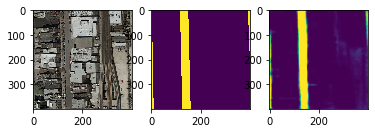

In [15]:
i = 56
pred = model.predict(x_norm[i:i+1])
plot([x_norm[i], y[i], pred[0].reshape(400,400)])

In [29]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow.image'

In [40]:
saturated_imgs = tf.image.adjust_saturation(x, 2.5)
saturated_imgs = tf.image.adjust_contrast(saturated_imgs, 1.5)

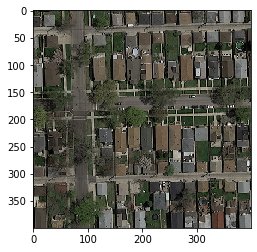

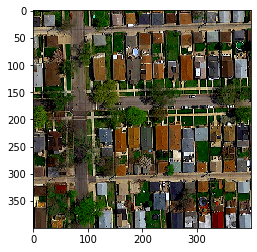

In [41]:
plot([x[5]])
plot([saturated_imgs[5]])

In [53]:
H = 0.0
Beta = 1.0
Eta = 1.0

**Implementation of the Ising Model Stuff**

In [48]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

Estimating loss via mean squared error

In [49]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [50]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

In [51]:
def meanfield(img_noisy_observation, img_original, epochs, T=1.0):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    
    N = img_noisy_observation.shape[0] * img_noisy_observation.shape[1]
    Nh = img_noisy_observation.shape[0]
    Nw = img_noisy_observation.shape[1]
    
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    energies = [E]
    losses = [L]
    
    c_bar = img_noisy_observation.copy()
    
    for e in range(epochs):
        a = (1/T) * (Beta * convolve(c_bar, np.asarray([[1,1,1], [1,0,1], [1,1,1]]), mode='constant', cval=0) + Eta * img_noisy_observation + 2*H)
        c_bar = np.tanh(a)
        
        energies.append(energy(c_bar, img_noisy_observation))
        losses.append(mse_loss(c_bar, img_original))
        
    return np.reshape(c_bar, img_noisy_observation.shape), np.asarray(energies), np.asarray(losses)

1.0 0.0
0.60753125
0.6733375


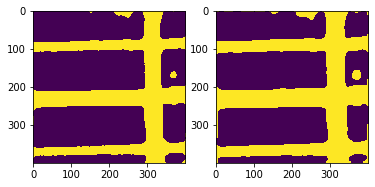

In [72]:
noisy = pred.reshape((400,400))
original = y[i]

denoised, _, _ = meanfield(noisy > 0.5, y[i], 3, T=0.1)
plot([noisy > 0.5, denoised])

print(denoised.max(), denoised.min())

print(skl.metrics.accuracy_score(original.ravel(), (denoised > 0.5).ravel()))
print(skl.metrics.accuracy_score(original.ravel(), (noisy > 0.5).ravel()))

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method by answering these two questions.
    <br>1) How can we tell if the mean field convereged? 
    <br>2) Do we always reach the global optimum?
</p>

1) In order to declare convergence, I would compare the assignments $\bar{c}$ to the ones from the previous iterate, and once the norm of their difference is $< \varepsilon$ for some given tolerance $\varepsilon$, stop.

2) Since we use an EM-like update, we can certainly not hope for global convergence. However, according to Thm 1 in [1], we are guaranteed to find a local minimum.

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the temperature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. 
    <br>1) Can you explain the behaviour? 
    <br>2) Do you see a difference in the reconstraction at different temperature?
</p>

First of all, let me recreate the awesome results from before by simulating the ('false') update step I used first, by setting $\eta \leftarrow \beta$.

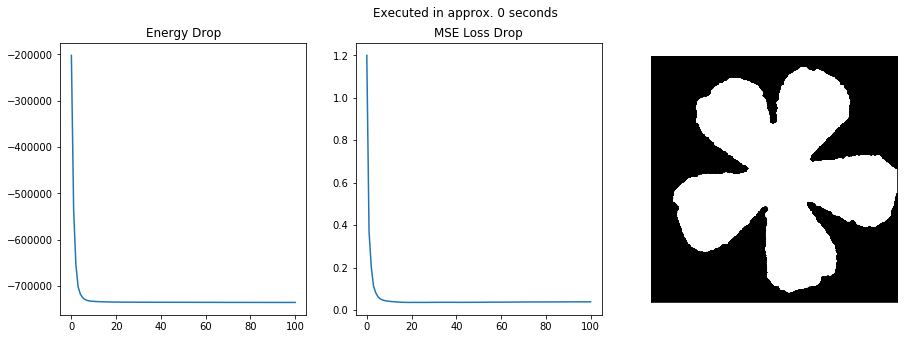

Final Energy: -735864.625, Final Loss:0.03872234928260309


In [322]:
Eta = Beta
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 100)

Now, let us compare different temperatures (with Eta = Beta, and H=0 still fixed)

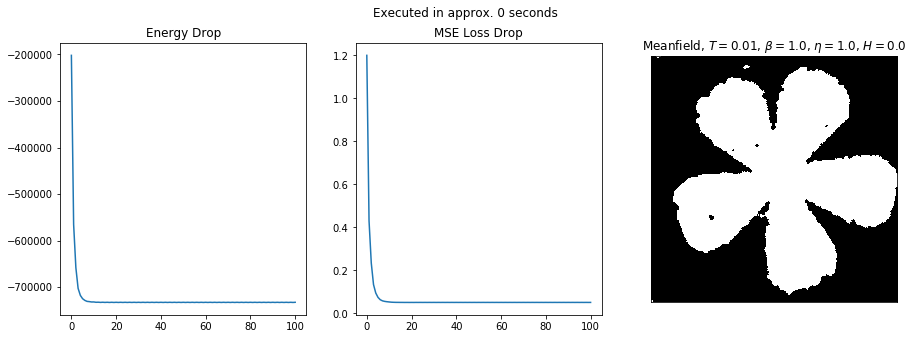

Final Energy: -732429.0, Final Loss:0.05101111111111111


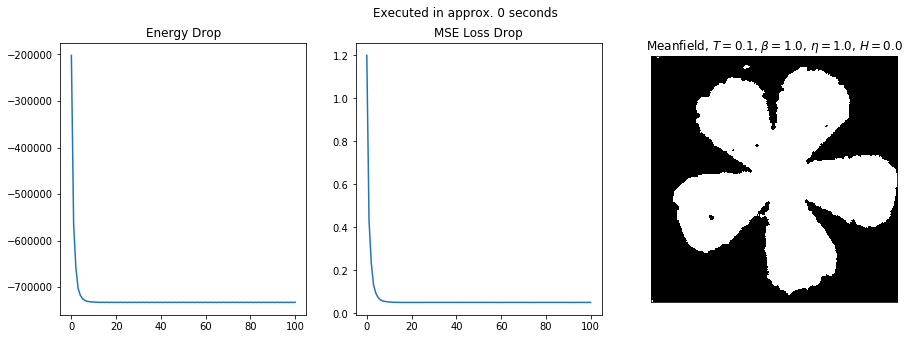

Final Energy: -732429.0, Final Loss:0.05101111111111111


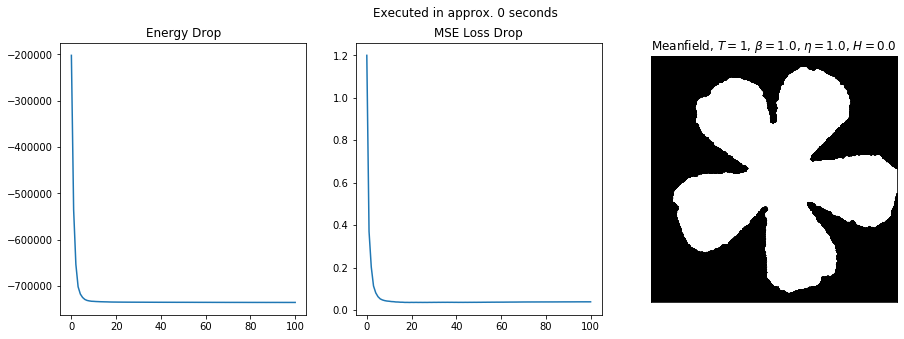

Final Energy: -735864.625, Final Loss:0.03872234928260309


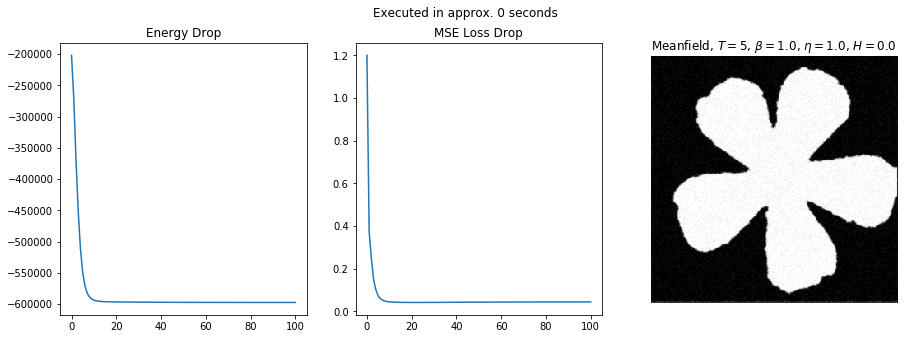

Final Energy: -597087.9375, Final Loss:0.04442618445812563


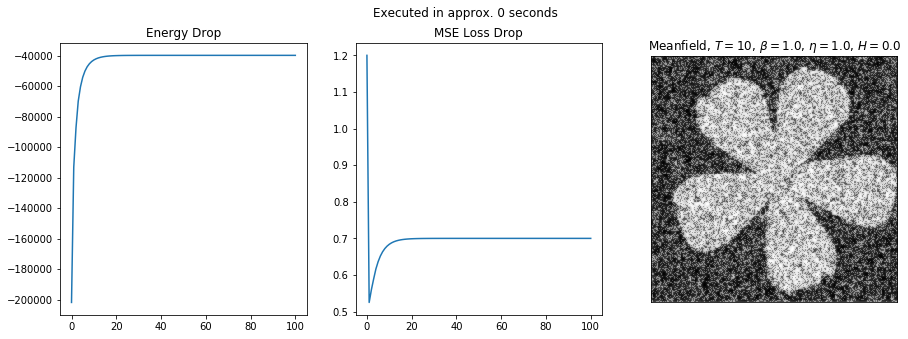

Final Energy: -39868.91796875, Final Loss:0.7002514046794792


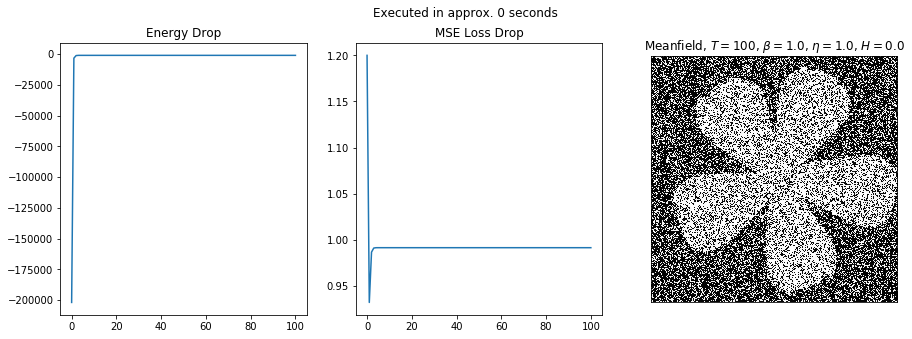

Final Energy: -927.202392578125, Final Loss:0.9914297718970153


In [326]:
Ts = [0.01, 0.1, 1, 5, 10, 100]

for T in Ts:
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 100, T=T, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(T, Beta, Eta, H))

The above behaviour is actually pretty much what should be expected: with the temperature too low, we "force" our algorithm into a bad local minimum -- which is quite obviously a minimum, but not a global one. With increasing temperature, we actually find our global minimum, but once we go too far, we can see that our algorithm is unable to even find a local minimum because the Gibbs distribution becomes "too flat", and a configuration with still considerable noise is output.

Now, let's fix the temperature back to 1 which experimentally appears to be a good value and see if changing the $H$ value has an influence.

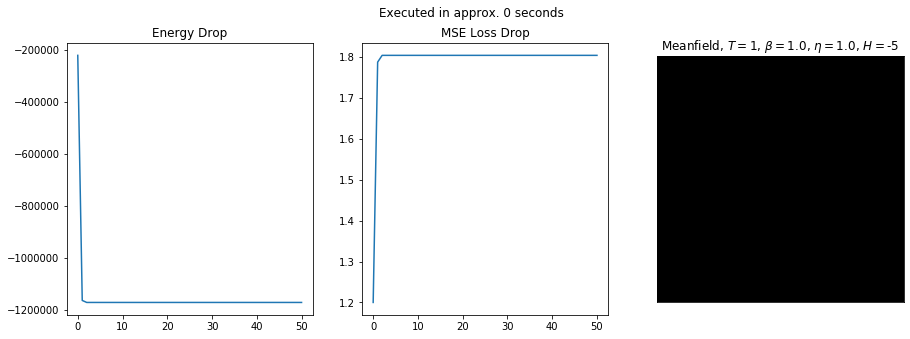

Final Energy: -1170260.0, Final Loss:1.8038222222222222


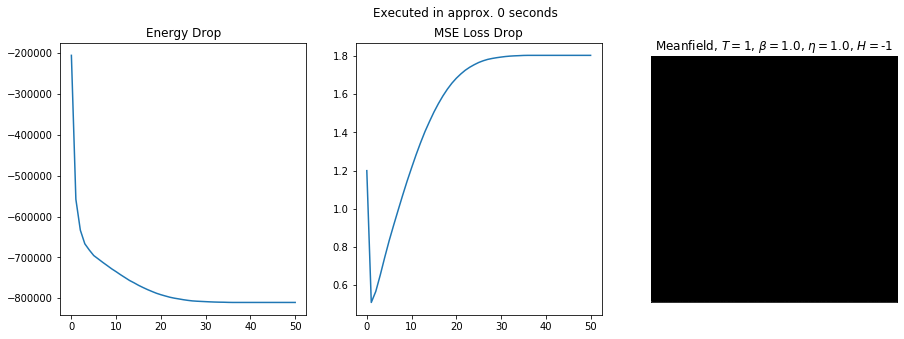

Final Energy: -810260.0, Final Loss:1.803822145531263


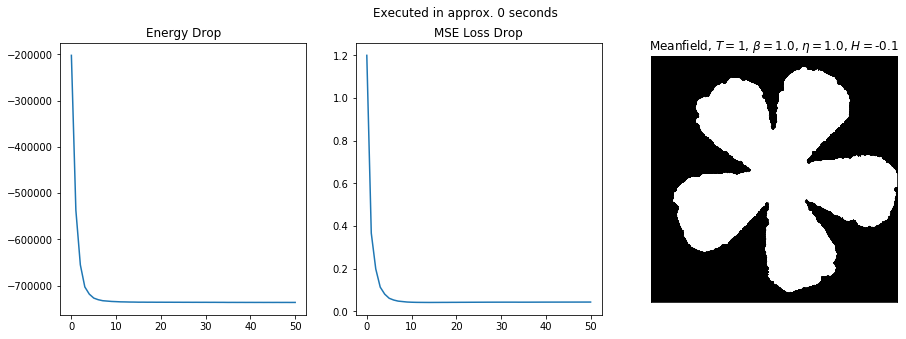

Final Energy: -736048.5, Final Loss:0.04415993678199637


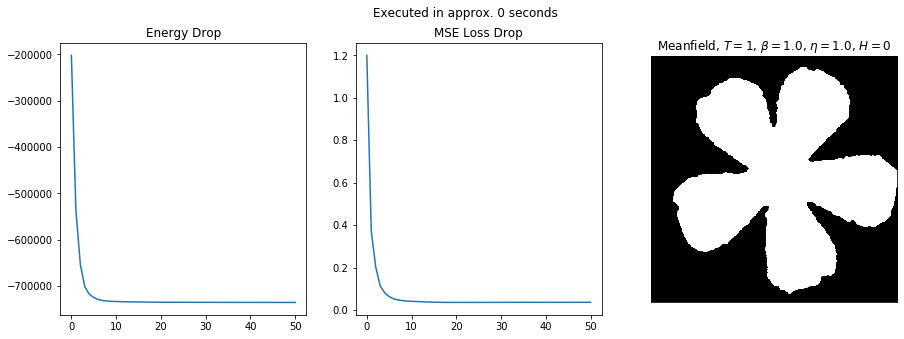

Final Energy: -735577.9375, Final Loss:0.03657937520179364


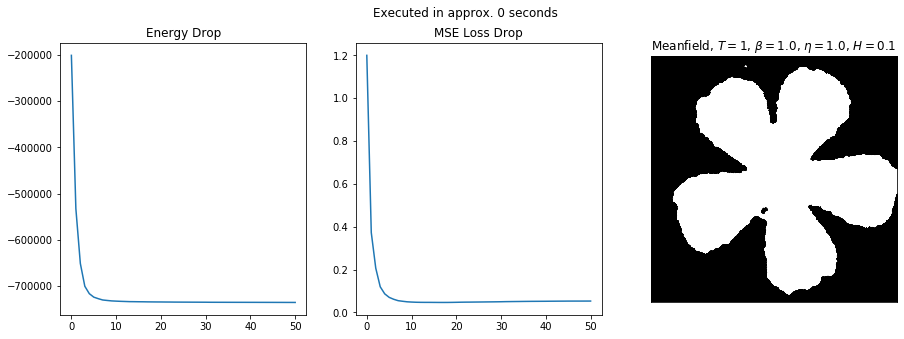

Final Energy: -734983.0625, Final Loss:0.053298781965640835


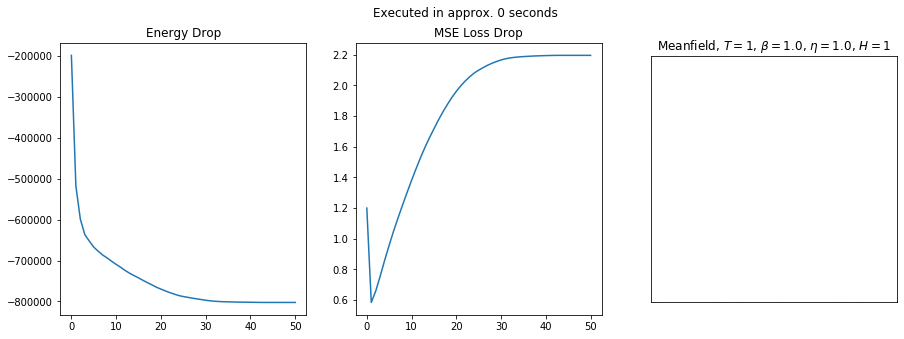

Final Energy: -802548.0, Final Loss:2.196177154234178


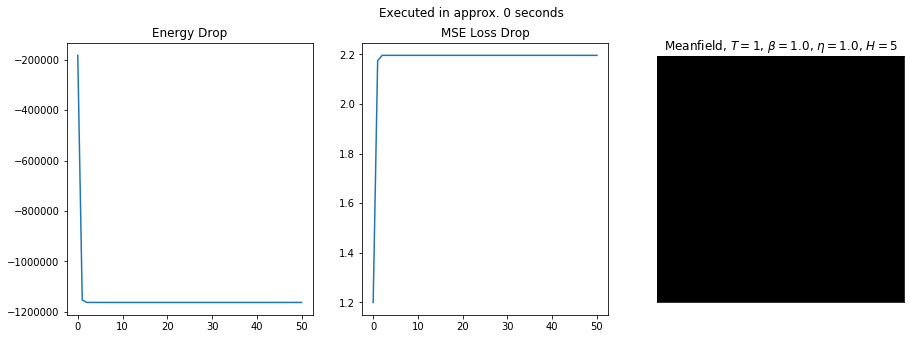

Final Energy: -1162548.0, Final Loss:2.196177777777778


In [333]:
Hs = [-5, -1, -0.1, 0, 0.1, 1, 5]
for h in Hs:
    H = h
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=50, T=1, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(1, Beta, Eta, H))

As we can see, the $H$ parameter introduces a strong bias towards either black or white (depending on the sign). This makes sense, as the energy function then has a portion that is the sum of the estimates itself, which becomes smallest when all values are the same. Equivalently, in the update step, we add a constant each time, shifting the values in one direction. 

The algorithm then finds energy minima that are just one uniform color,which obv. minimise the energy but are useless for this task.

Finally, let's set $H$ back to 0 and investigate $\eta, \beta$. For the sake of experimentation, let's first see what happens when we set either of them to 0 (and keep the other one fixed at the good value of 1)

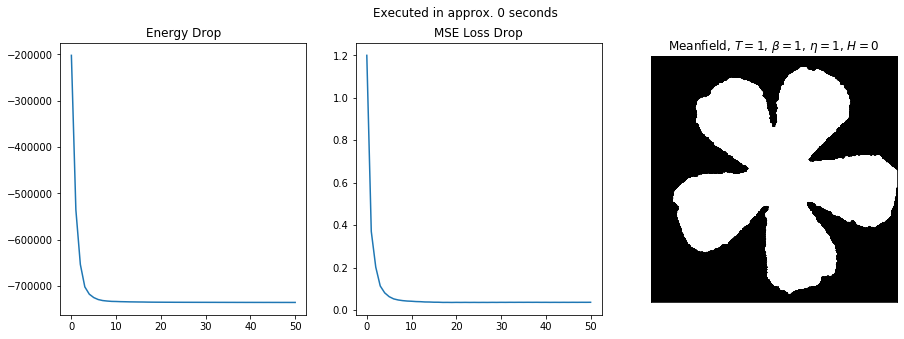

Final Energy: -735577.9375, Final Loss:0.03657937520179364


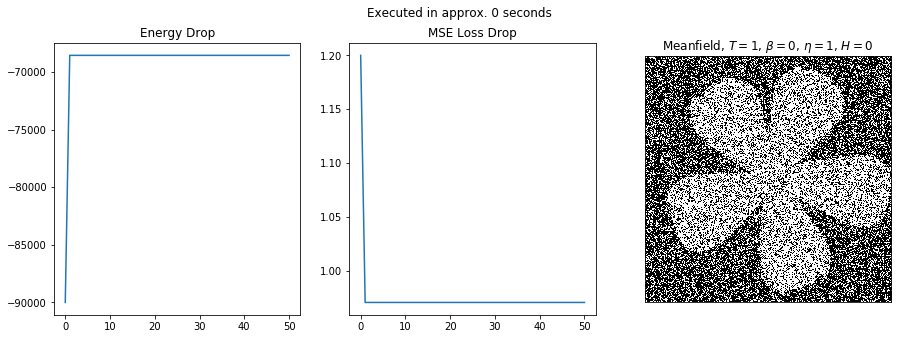

Final Energy: -68543.4765625, Final Loss:0.9707503483285933


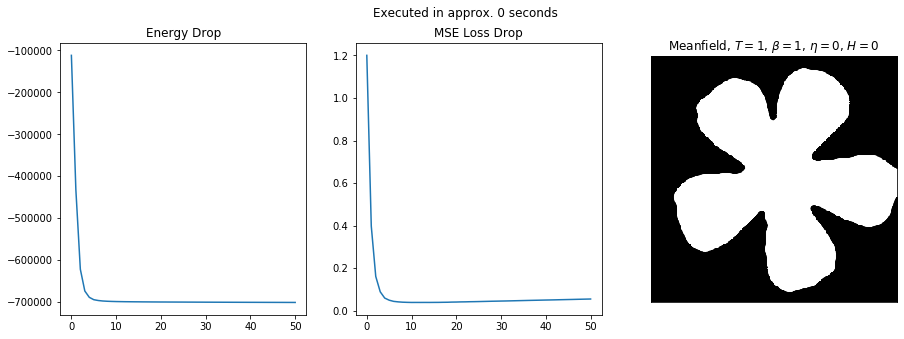

Final Energy: -700622.0, Final Loss:0.055543893539449295


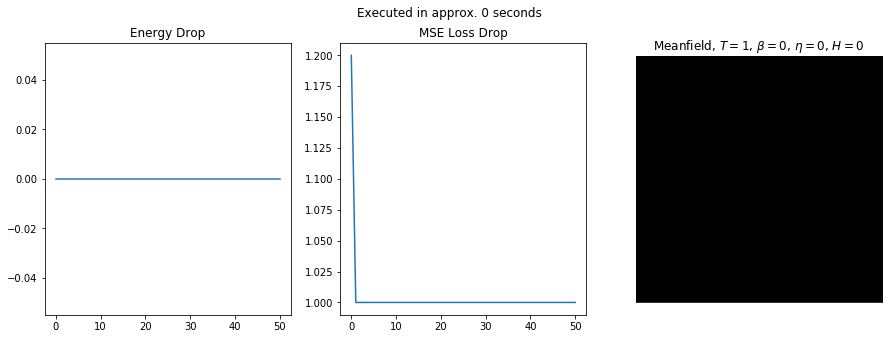

Final Energy: -0.0, Final Loss:1.0


In [336]:
H = 0
Etas = [1, 0]
Betas = [1, 0]

for e in Etas:
    for b in Betas:
        Eta = e
        Beta = b
        evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=50, T=1, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(1, Beta, Eta, H))

Unsuprisingly, if both are 0, nothing happens. What's interesting is that, at least visually, $\eta = 0$ produces a comparable result to the ideal configuration. That would indicate that even if we ignore the agreement with the original noisy observation, we can get decent results.

However, setting $\beta$ to zero has a to-be-expected outcome: Since we don't consider the neighbourhood of pixels anymore, virtually no denoising happens.

For the sake of playing around, let us also remark that setting $\beta < 0$ has the interesting effect of the result jumping around between a positive and negative configuration, both of low noise:

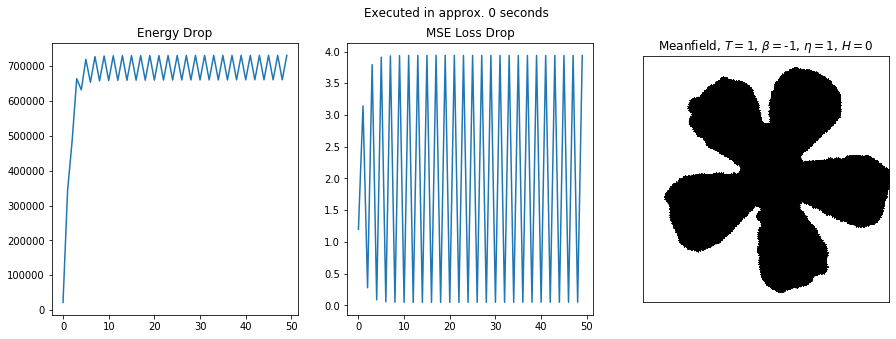

Final Energy: 731250.875, Final Loss:3.9365738693403602


In [338]:
Beta = -1
Eta = 1

evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=50, T=1, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(1, Beta, Eta, H))
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=49, T=1, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(1, Beta, Eta, H))

Finally, let us consider some $\beta, \eta$ combinations that are more ordinary and compare.

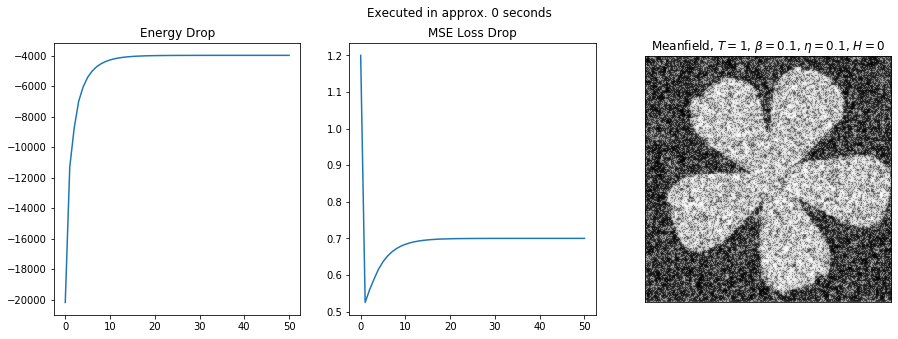

Final Energy: -3986.897216796875, Final Loss:0.7002510656725608


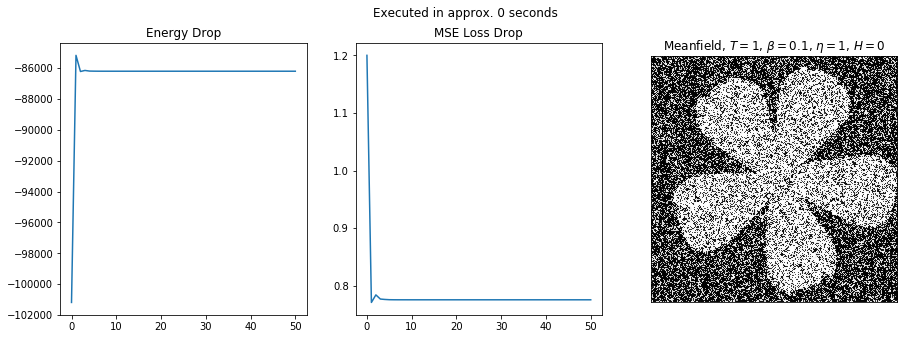

Final Energy: -86190.625, Final Loss:0.7757977665421811


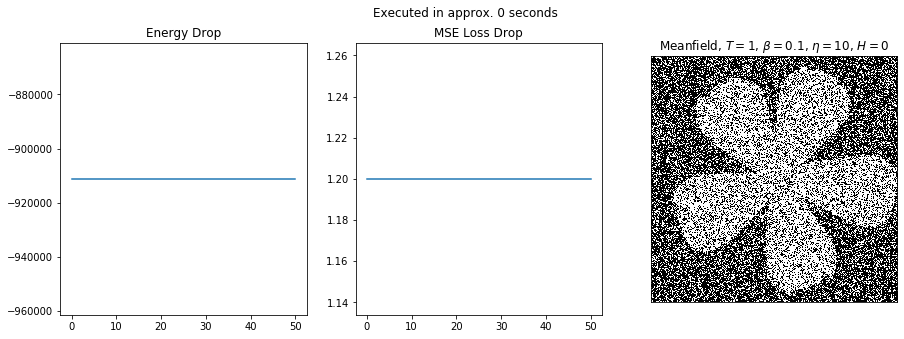

Final Energy: -911185.625, Final Loss:1.2


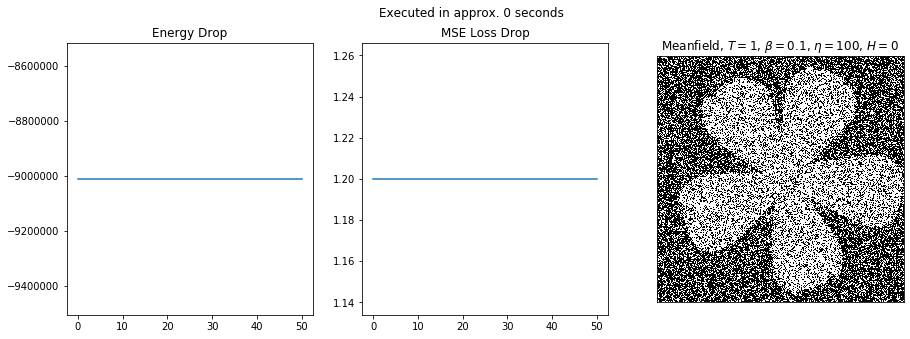

Final Energy: -9011186.0, Final Loss:1.2


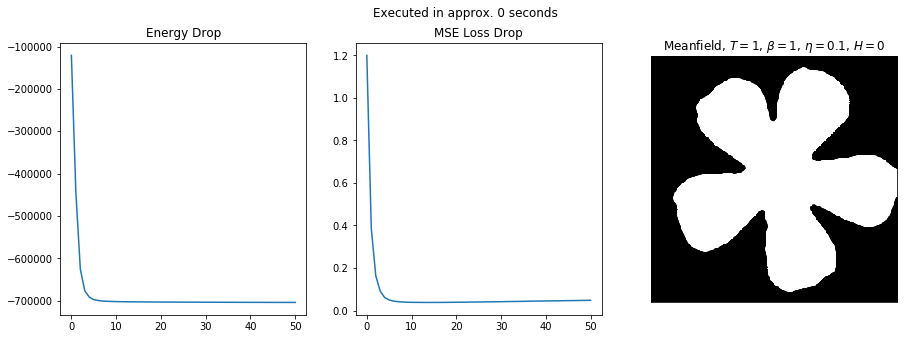

Final Energy: -704035.0625, Final Loss:0.048106602094289845


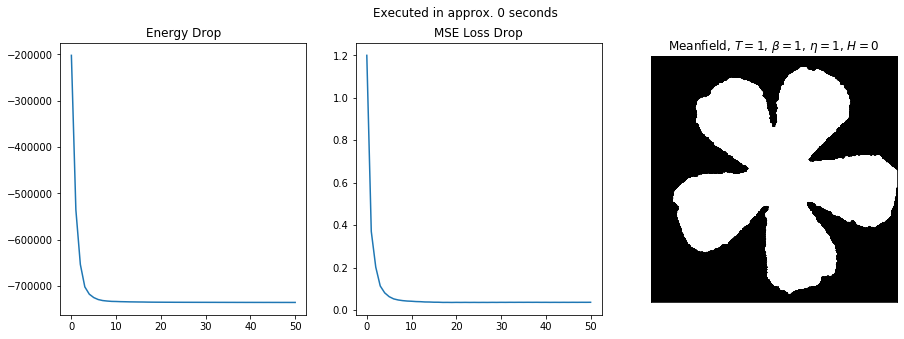

Final Energy: -735577.9375, Final Loss:0.03657937520179364


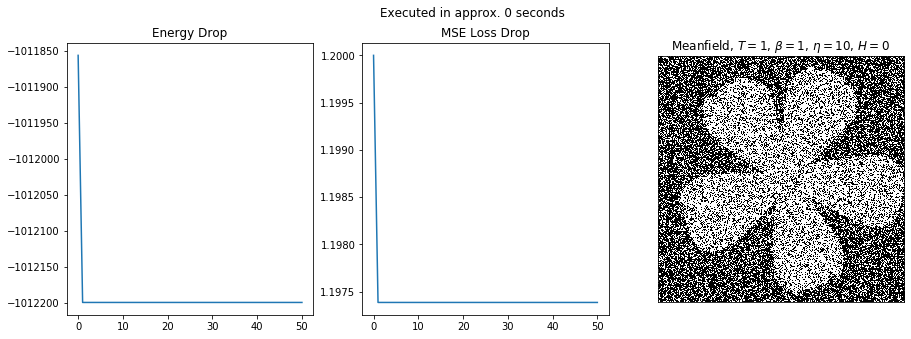

Final Energy: -1012199.3125, Final Loss:1.1973858763302876


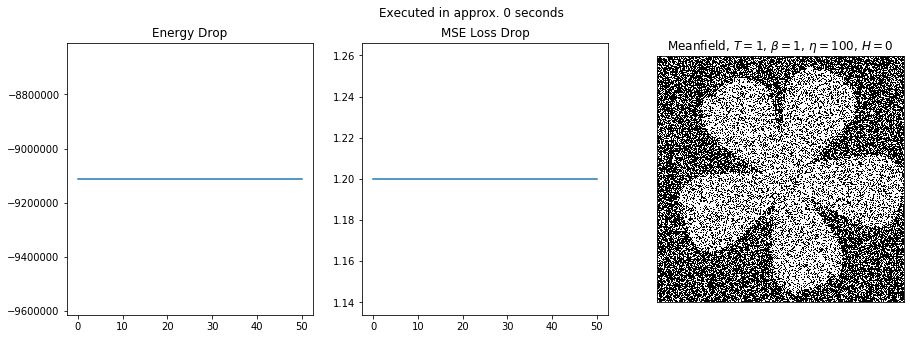

Final Energy: -9111856.0, Final Loss:1.2


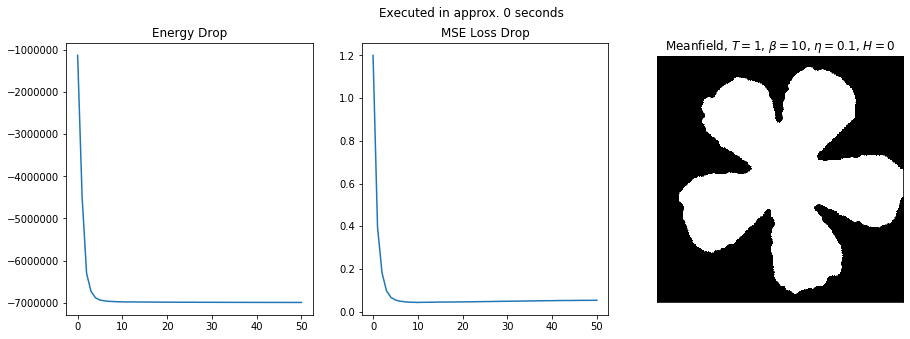

Final Energy: -6995335.5, Final Loss:0.053558092114511985


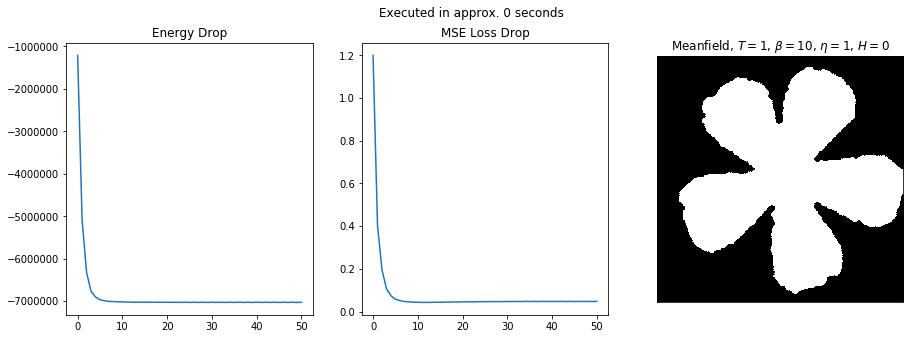

Final Energy: -7023961.0, Final Loss:0.047383202398151


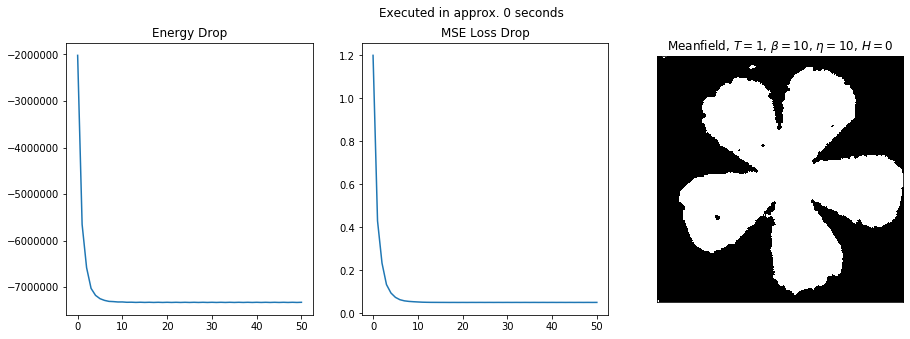

Final Energy: -7324290.0, Final Loss:0.05101111111111111


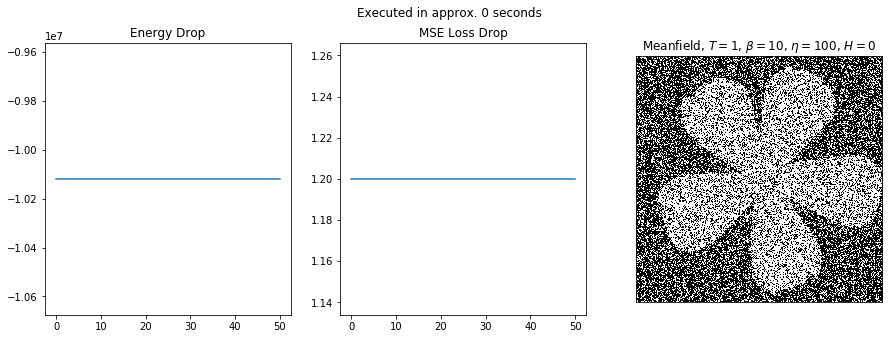

Final Energy: -10118560.0, Final Loss:1.2


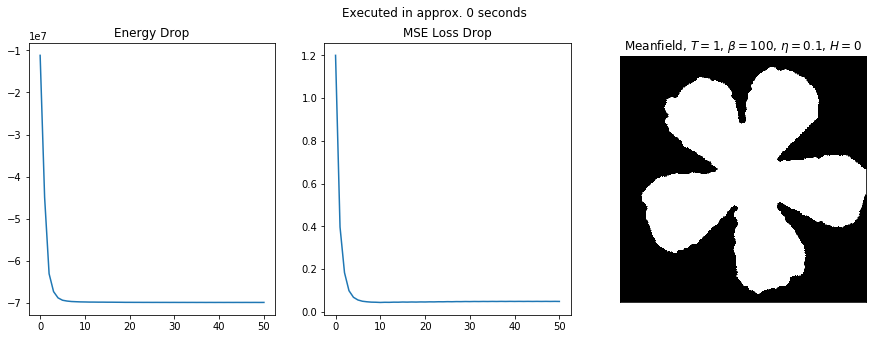

Final Energy: -69865840.0, Final Loss:0.04841155297673116


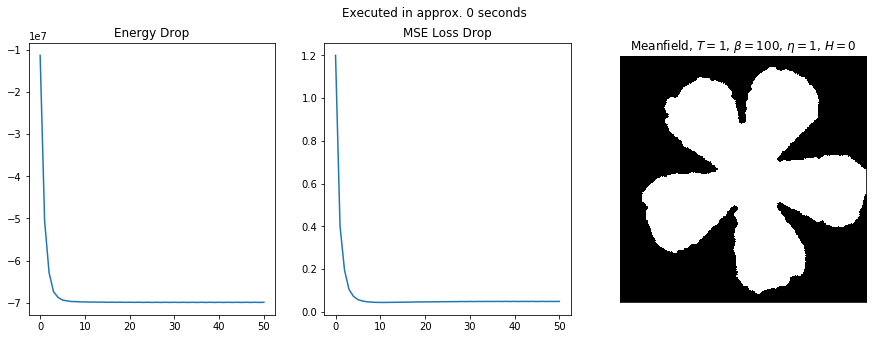

Final Energy: -69890032.0, Final Loss:0.04880631818527073


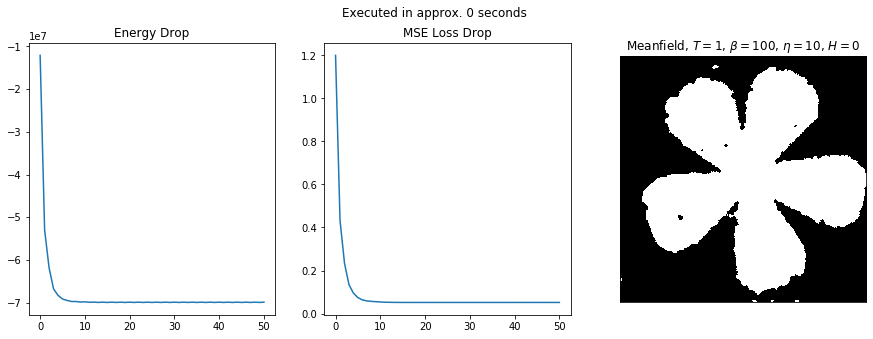

Final Energy: -69906960.0, Final Loss:0.05173333333333333


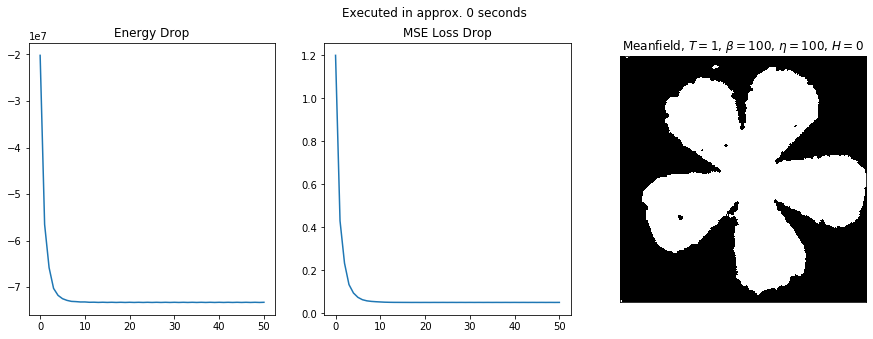

Final Energy: -73242896.0, Final Loss:0.05101111111111111


In [339]:
Betas = [0.1, 1, 10, 100]
Etas = [0.1, 1, 10, 100]

for b in Betas:
    for e in Etas:
        Beta = b
        Eta = e
        evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=50, T=1, title="Meanfield, $T=${}, $\\beta=${}, $\\eta=${}, $H=${}".format(1, Beta, Eta, H))

As we can see, $\beta = \eta = 1$ really seems to be the best option.

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    For this and for all the following tasks, you have to use a different dataset: the <b>Wine data set</b> in [4] (this is <b>not</b> the Wine Dataset in previous coding exercise - please download the one in [4]). This data set contains three classes, see more detailed description online. 
    <br><br>
    Implement both (1) plain-vanilla k-means and (2) smooth k-means in mean field [1], and compare them on the Wine data set.
</p>

In [244]:
columns = ["label", 
           "Alcohol",
           "Malic acid",
           "Ash",
           "Alcalinity of ash",
           "Magnesium",
           "Total phenols",
           "Flavanoids",
           "Nonflavanoid phenols",
           "Proanthocyanins",
           "Color intensity",
           "Hue",
           "OD280/OD315",
           "Proline",
]

wine_data = pd.read_csv('wine.data', names=columns)
wine_X = np.asarray(wine_data[columns[1:]])
wine_y = np.asarray(wine_data['label'])
nb_wines = wine_X.shape[0]

In [286]:
class VanillaKMeans(skl.base.BaseEstimator):
    
    def __init__(self, n_clusters=3, iterations=100, Tmax=100.0, init='kmeans', verb=False):
        self.n_clusters = n_clusters
        self.iterations = iterations
        self.Tmax = Tmax
        self.init = init
        self.verb = verb
        
    def _risk(self, X, y, c):
        """
        Implements the risk function for vanilla k-means.
        
        Args:
                X: The design matrix, shape (n_samples, n_dims)
                y: The current cluster centroids, shape (n_clusters, n_dims)
                c: The current cluster assignments, shape (n_samples,)
                
        Returns: The sum over all squared distances from the data points to the assigned cluster centroid.
        """
                
        diff = X - y[c]
        return np.sum(diff * diff)
    

    def _meanfields(self, X, y, P):
        return -2 * X @ y.T + np.sum(X**2 ,axis=1)[:, None] + np.sum(y**2, axis=1)
        
        
    def fit(self, X):
        self.n_dims = X.shape[1]
        
        if self.init == 'random':
            y = np.random.rand(self.n_clusters, self.n_dims)
        else:
            y = skl.cluster.k_means_._k_init(X, 
                                             self.n_clusters, 
                                             np.linalg.norm(X, axis=1)**2, 
                                             random_state=skl.utils.check_random_state(13))
        n_samples = X.shape[0]
        
        best_centroids = y
        best_assignments = np.zeros(n_samples)
        best_risk = np.inf
        
        T = self.Tmax
        P = np.random.rand(n_samples, self.n_clusters)
        P /= np.sum(P, axis=1)[:, None]
        for it in range(self.iterations):
            if self.verb:
                print("T = {}".format(T))
            H = self._meanfields(X, y, P)
            P = softmax(-(1/T) * H, axis=1)
            assert(np.allclose(np.sum(P, axis=1), 1))
            
            y = P.T @ X / np.sum(P, axis=0)[:, None]
            T /= 2
            
            c = np.argmax(P, axis=1)
            risk = self._risk(X, y, c)
            if risk < best_risk:
                best_centroids = y
                best_assignments = c
                best_risk = risk
            
        
        self.centroids = best_centroids
        self.assignments = best_assignments

In my implementation, I made the temperature decrease as in DA, in order to actually make progress and to make it slightly less susceptible on the temperature parameter (provided that iterations > 1)

To make this a little more interesting, I will do sevaral different tests with different temps, iterations and initialisations. First, let's see how 'regular' KMeans performs as a baseline:

In [159]:
kmeans = skl.cluster.KMeans(3)
kmeans.fit(wine_X)

print(adjusted_mutual_info_score(wine_y, kmeans.labels_))

0.42263142262401465


/Users/remogeissbuehler/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Now, let us see how our implementation with the advantageous K-Means Initialisation performs with only one fixed temperature:

In [287]:
for t in [0.001, 0.1, 1.0, 100, 1000, 10000]:
    vkm = VanillaKMeans(Tmax = t, iterations=1, init='kmeans', verb=True)
    vkm.fit(wine_X)
    print(adjusted_mutual_info_score(wine_y, vkm.assignments))


T = 0.001
0.40113080260136974
T = 0.1
0.40113080260136974
T = 1.0
0.40113080260136974
T = 100
0.40113080260136974
T = 1000
0.40113080260136974
T = 10000
0.40113080260136974


As we can see, irrespective of the temperature, all results are the same. Indeed, this makes sense as the initialisation is already a strong guide and therefore, the algorithm finds a 'good' minimum immediately at every temperature. Note also that the score is almost as good as the 'reference' implementation.

Now, let us try the random initialisation with just one iteration.

In [291]:
for t in [0.001, 0.1, 1.0, 100, 1000, 10000]:
    vkm = VanillaKMeans(Tmax = t, iterations=1, init='random', verb=True)
    vkm.fit(wine_X)
    print(adjusted_mutual_info_score(wine_y, vkm.assignments))

T = 0.001
-6.013007014545953e-16
T = 0.1
-6.013007014545953e-16
T = 1.0
0.31742217262683
T = 100
-6.013007014545953e-16
T = 1000
-6.013007014545953e-16
T = 10000
-6.013007014545953e-16


/Users/remogeissbuehler/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


As we can see, we now get potentially different (and very bad) results. That makes sense as well, as with a random vector we cannot reasonably expect it to find a good minimum immediately. Let us try with a few iterations

In [292]:
for t in [0.001, 0.1, 1.0, 100, 1000, 10000]:
    vkm = VanillaKMeans(Tmax = t, iterations=10, init='kmeans')
    vkm.fit(wine_X)
    print(adjusted_mutual_info_score(wine_y, vkm.assignments))

0.4226314226240146
0.4226314226240146
0.4226314226240146
0.4226314226240146
0.4226314226240146
0.4226314226240146


As we can see, this provides much better results, indeed the same as the reference one. Last, but not least, let's see about k-means init with a few iterations, which we would also expect to turn out great:

In [224]:
for t in [0.001, 0.1, 1.0, 100, 1000, 10000]:
    vkm = VanillaKMeans(Tmax = t, iterations=5, init='kmeans')
    vkm.fit(wine_X)
    print(adjusted_mutual_info_score(wine_y, vkm.assignments))

T = 0.001
T = 0.0005
T = 0.00025
T = 0.000125
T = 6.25e-05
0.42534602466880056
T = 0.1
T = 0.05
T = 0.025
T = 0.0125
T = 0.00625
0.42534602466880056
T = 1.0
T = 0.5
T = 0.25
T = 0.125
T = 0.0625
0.42534602466880056
T = 100
T = 50.0
T = 25.0
T = 12.5
T = 6.25
0.42534602466880056
T = 1000
T = 500.0
T = 250.0
T = 125.0
T = 62.5
0.42534602466880056
T = 10000
T = 5000.0
T = 2500.0
T = 1250.0
T = 625.0
0.42534602466880056


Indeed, that one performs even slightly better than the 'reference' one.  

Now onto the neighbourhood version. Really the only thing we have to replace is the line where the $h_{u, \alpha}$ (in the code called `H`) are calculated, using the formula on page 14 of [1]. In the implementation, we will use a matrix $\mathsf{NB} \in \mathbb{R}^{N\times N}$, ($N$ the number of data points) to describe "Neighbourship". In particular, $\mathsf{NB}_{ij} = 1 \iff j \in \mathcal{N}(i)$, where $\mathcal{N}(u)$ describes the neighbour set of data point u as in [1].

In [184]:
c = np.asarray([0,1,1,0,0,2])
b = np.zeros((c.size, c.max()+1))
b[np.arange(c.size),c] = 1

ind = b @ b.T

(1 - np.eye(6,6)) * ind

array([[0., 0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [294]:
class SmoothKMeans(VanillaKMeans):
    
    def __init__(self, n_clusters=3, iterations=100, Tmax=100.0, init='kmeans', NB=None, Lambda=1, verb=False):
        self.n_clusters = n_clusters
        self.iterations = iterations
        self.Tmax = Tmax
        self.init = init
        self.NB = NB
        self.Lambda = Lambda
        self.verb = verb
        
    @staticmethod
    def agreement_matrix(c):
        one_hot = np.zeros((c.size, c.max()+1))
        one_hot[np.arange(c.size),c] = 1
        indicator = one_hot @ one_hot.T
        return indicator
        
    def _risk(self, X, y, c):
        if self.NB is None:
            self.NB = np.zeros((X.shape[0], X.shape[0]))
        
        diff = X - y[c]
        
        indicator = self.agreement_matrix(c)
        
        regulariser = (self.Lambda / 2) * np.sum(self.NB * indicator)
        return np.sum(diff * diff) + regulariser
    
    def _meanfields(self, X, y, P):
        if self.NB is None:
            self.NB = np.zeros((X.shape[0], X.shape[0]))
        mutual_distances = -2 * X @ y.T + np.sum(X**2 ,axis=1)[:, None] + np.sum(y**2, axis=1)
        
        NB_times_P = self.NB @ P
        regulariser = self.Lambda * (np.sum(NB_times_P, axis=1)[:, None]  - NB_times_P)
        
        return mutual_distances + regulariser

In [295]:
# Using something artificial first, to test implementation and find 'oracle optimum' by using 
# the given labels as criteria for 

NB_opt = SmoothKMeans.agreement_matrix(wine_y)
smkm = SmoothKMeans(NB=NB_opt, iterations=10, Lambda=1000)
smkm.fit(wine_X)

adjusted_mutual_info_score(wine_y, smkm.assignments)

0.530697624223297

Indeed, the score becomes higher with the insider information, albeit only with high values of $\lambda$.

Another possibility would be to group the wines beforehand, and declaring each wine's top $\Xi \in \mathbb{N}$ closest points its neighbours.

In [358]:
Xi = 7
NB_Xi = np.zeros((nb_wines, nb_wines))
mutual_distances =  -2 * wine_X @ wine_X.T + np.sum(wine_X**2 ,axis=1)[:, None] + np.sum(wine_X**2, axis=1)


for i in range(nb_wines):
    top_Xi = np.argsort(mutual_distances[i])[:Xi]
    NB_Xi[i, top_Xi] = 1

for l in [100, 1000, 10000]:
    smkm_Xi = SmoothKMeans(NB=NB_Xi, iterations=5, Lambda=l, Tmax=10)
    smkm_Xi.fit(wine_X)
    print("Lambda = {}".format(l))
    print(adjusted_mutual_info_score(wine_y, smkm_Xi.assignments))

Lambda = 100
0.42534602466880056
Lambda = 1000
0.41774389285693797
Lambda = 10000
0.4003490928896457


As we can see, that was a total failure. The proximity itself seems to introduce an unwanted bias, after all, with high values of lambda, the score even deteriorates.

In [398]:
wine_normed = wine_X / np.linalg.norm(wine_X, axis=1)[:, None]

Xi = 20
NB_Xi = np.zeros((nb_wines, nb_wines))
mutual_angles =  wine_normed @ wine_normed.T


for i in range(nb_wines):
    top_Xi = np.argsort(mutual_angles[i])[:Xi]
    NB_Xi[i, top_Xi] = 1

for l in [0, 100, 1000, 10000]:
    smkm_Xi = SmoothKMeans(NB=NB_Xi, iterations=5, Lambda=l, Tmax=10)
    smkm_Xi.fit(wine_X)
    print("Lambda = {}".format(l))
    print(adjusted_mutual_info_score(wine_y, smkm_Xi.assignments))

Lambda = 0
0.42534602466880056
Lambda = 100
0.42534602466880056
Lambda = 1000
0.40751305818177475
Lambda = 10000
0.4319669752516303


The above is a shot at 'least-angling neighbourhood', which doesn't work super well either. There is the occasional lucky-punch, like the run above that I kept for the record, but in most of them, it performs badly. Last but not least, let's try something RBF-inspired.

In [417]:
sigma = 5.0
NB_RBF = np.exp(-mutual_distances / sigma**2)

for l in [0, 1, 10, 100, 1000, 10000]:
    smkm_rbf = SmoothKMeans(NB=NB_RBF, iterations=5, Lambda=l, Tmax=10)
    smkm_rbf.fit(wine_X)
    print("Lambda = {}".format(l))
    print(adjusted_mutual_info_score(wine_y, smkm_rbf.assignments))

Lambda = 0
0.42534602466880056
Lambda = 1
0.42534602466880056
Lambda = 10
0.42534602466880056
Lambda = 100
0.42534602466880056
Lambda = 1000
0.4239187721102603
Lambda = 10000
0.4486985612151171


Indeed, with very high values of sigma and $\lambda$, this seems to deliver a slight improvement. Note however that we slightly reinterpreted the neigbhourhood as something continuous rather than binary (which in itself doesn't seem like a bad idea)

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

In [421]:
pca = skl.decomposition.PCA(2)
wine_2d = pca.fit_transform(wine_X)

k_means_ = VanillaKMeans(3, iterations=5)
k_means_.fit(wine_X)
k_means_labels = k_means_.assignments

In [437]:
def visualise_labelling(X, y, title=''):
    plt.figure()
    plt.title(title)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

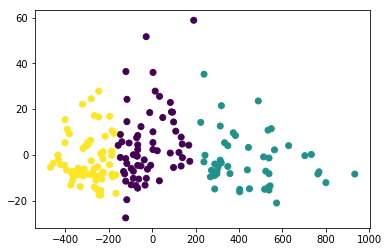

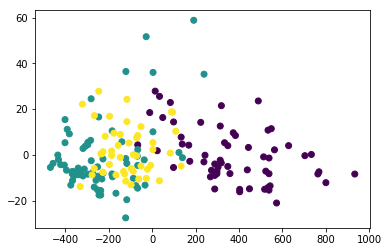

In [438]:
visualise_labelling(wine_2d, k_means_labels)
visualise_labelling(wine_2d, wine_y)

<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

As we have seen above, smooth k-means doesn't really improve the (not so great) results of clustering. Looking at the graphs above, that seems to make sense because the actual ground truth doesn't seem to be very nicely clustered in Euclidean space (at least not in 2D), as the kmeans clustering would be. 

It is however possible that some other clever neighbourhood relatioship would improve that.

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). 
    <br>1) Does it indicate 3 clusters? 
    <br>2) How does the smooth k-means clustering solution change when varying the temperature of the mean field approximation?
</p>

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

I thought it was a good one (I'm actually quite amazed at the denoising), unfortunately I ran out of time for the rest of 6.0